In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pickle import dump, load
import missingno as msno
from scipy import interpolate

       Unnamed: 0  WELLNUM         DEPTH        DTC  DTS       DEN         GR  \
0               0        0  14121.660105   89.64610  NaN  2.577700   88.85730   
1               1        0  14122.160105   96.01520  NaN  2.474800  120.89490   
2               2        0  14122.660105  104.04570  NaN  2.333800  153.51950   
3               3        0  14123.160105  113.50100  NaN  2.235800  182.85310   
4               4        0  14123.660105  117.78170  NaN  2.227800  256.19600   
...           ...      ...           ...        ...  ...       ...        ...   
42304       42304        8  12142.500000   64.57612  NaN  2.613020   32.91600   
42305       42305        8  12143.000000   66.20669  NaN  2.614332   28.76523   
42306       42306        8  12143.500000   67.43187  NaN  2.620479   25.70403   
42307       42307        8  12144.000000   66.56465  NaN  2.623435   22.94222   
42308       42308        8  12144.500000   66.92158  NaN  2.617516   22.30438   

            NEU      PEF   

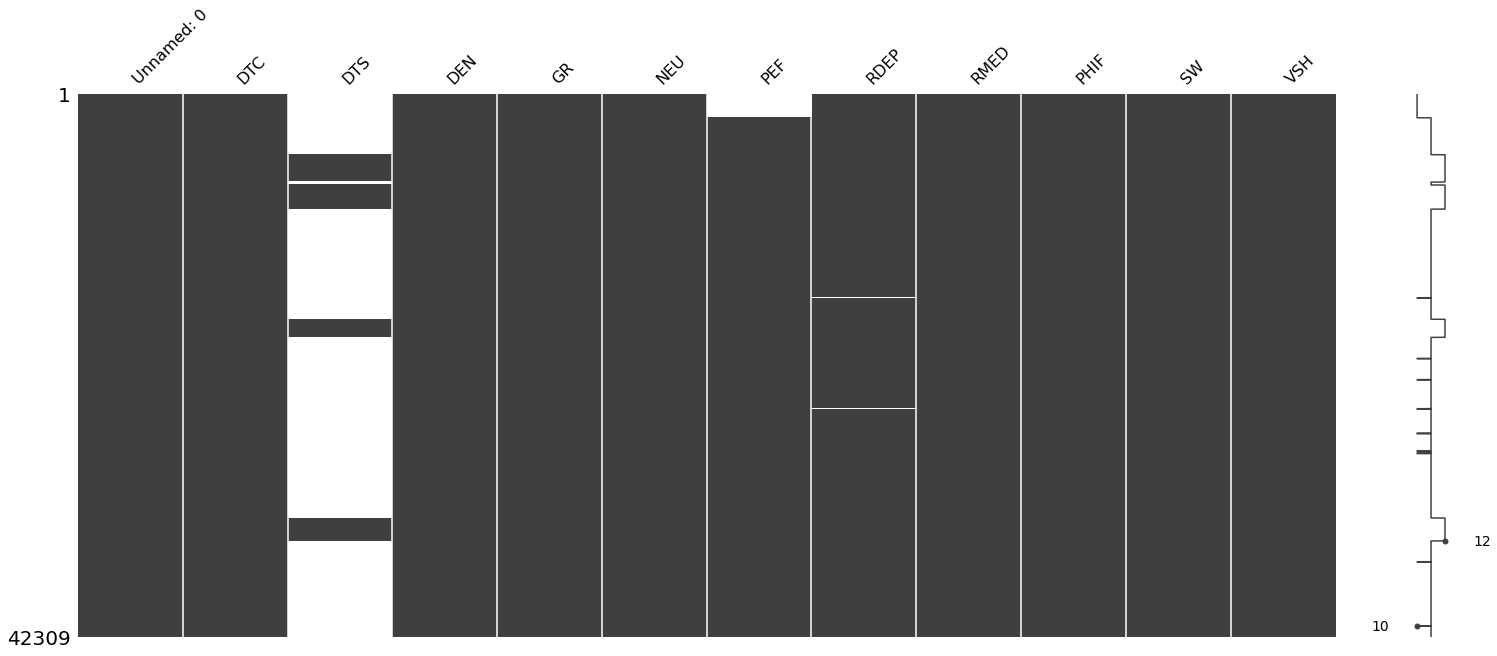

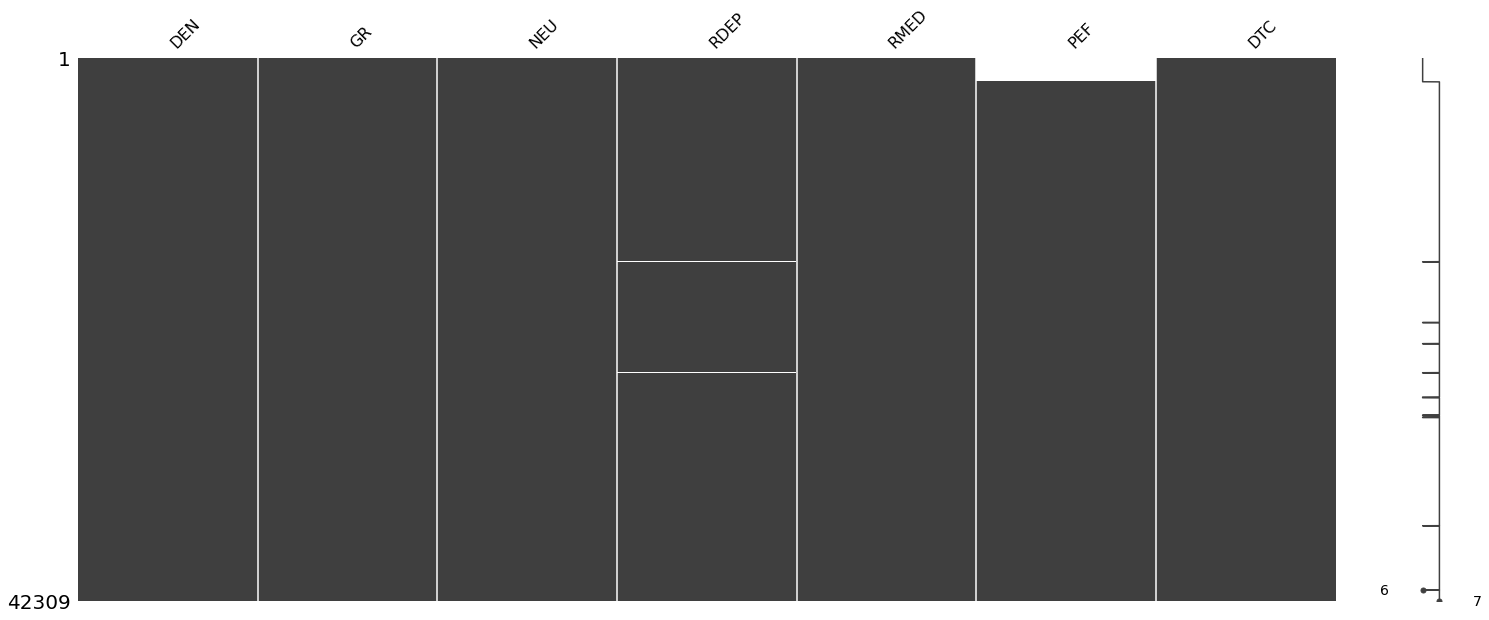

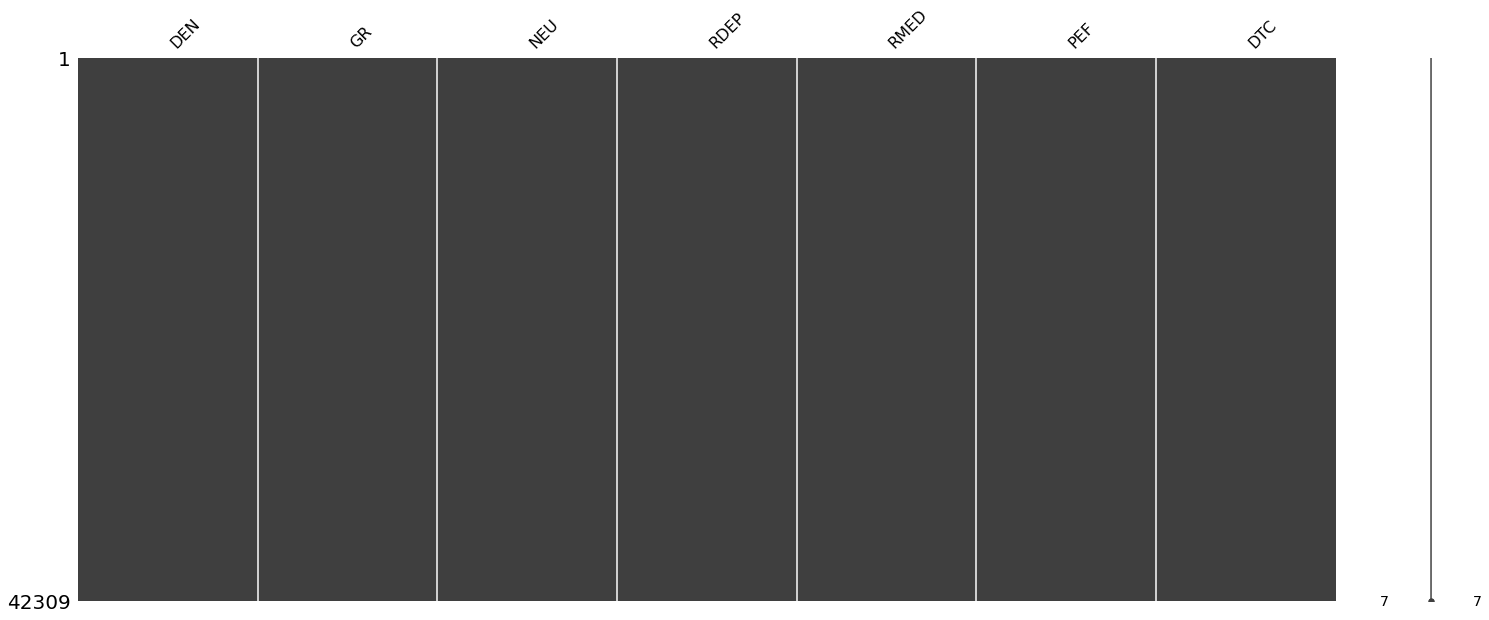

In [2]:
#Load Dataset
train_path = r"/Users/astromeria/PycharmProjects/SPWLA_2021_Geolatinas/dataset_filling/dtc_predictions/train_dataset_dtc_2.csv"

train_data = pd.read_csv(train_path)
print(train_data)

discarded =  ["WELLNUM", "DEPTH"]
targets = ['PHIF', 'SW', 'VSH']
features = ["DEN","GR","NEU", "RDEP","RMED", "PEF", "DTC"]
train_data = train_data.drop(columns=discarded)
print(len(train_data))
#train_data = train_data.dropna()

print(len(train_data))

msno.matrix(train_data)

#separate in x (inputs) and y(targets or outputs)
x_train = train_data.loc[:, features]
y_train = train_data.loc[:, targets]
msno.matrix(x_train)
print(y_train.describe())
#y_train.loc[y_train["SW"] < 0, "SW"] = 0
#y_train.loc[y_train["SW"] > 1, "SW"] = 1
#y_train.loc[y_train["PHIF"] < 0, "PHIF"] = 0
#y_train.loc[y_train["PHIF"] > 1, "PHIF"] = 1
#y_train.loc[y_train["VSH"] < 0, "VSH"] = 0
print(y_train.describe())


x_train = x_train.interpolate()
pef_mean = np.mean(x_train["PEF"])
print(pef_mean)
x_train['PEF'] = x_train['PEF'].fillna(pef_mean)
msno.matrix(x_train)

print(x_train)
print(y_train)


#x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.15)

#Normalize data
sc = StandardScaler()
x_train = pd.DataFrame(sc.fit_transform(x_train))
#save scaler to transform data for predictions
dump(sc, open('data_scalers/std_scaler_data100v4.pkl', "wb"))





In [3]:
#model
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(x_train.keys())]),
    layers.Dropout(0.1),
   
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.1),
   
    
    layers.Dense(len(y_train.keys()))
  ])
  optimizer = tf.keras.optimizers.Adam(0.001)
  model.compile(loss="mse",
                optimizer=optimizer,
                metrics=[ tf.keras.metrics.RootMeanSquaredError()])
  return model

#create a model instance
checkpoint_path = r"/Users/astromeria/Documents/SPWLA_competition/weights/100Data1FebV4.h5"
checkpoint = keras.callbacks.ModelCheckpoint( checkpoint_path, save_best_only=True, monitor = "val_loss")
model = build_model()

history = model.fit(
  x_train, y_train,
  epochs=200, validation_split = 0.10, verbose=2, callbacks = checkpoint)#just 10% for validation to use most of the data on training
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()
#plot_history(history)

2022-02-01 15:05:37.243164: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-01 15:05:37.288972: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/200
1190/1190 - 1s - loss: 0.0143 - root_mean_squared_error: 0.1195 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0702
Epoch 2/200
1190/1190 - 1s - loss: 0.0050 - root_mean_squared_error: 0.0707 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0469
Epoch 3/200
1190/1190 - 1s - loss: 0.0037 - root_mean_squared_error: 0.0609 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0494
Epoch 4/200
1190/1190 - 1s - loss: 0.0033 - root_mean_squared_error: 0.0573 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0494
Epoch 5/200
1190/1190 - 1s - loss: 0.0030 - root_mean_squared_error: 0.0552 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0362
Epoch 6/200
1190/1190 - 1s - loss: 0.0028 - root_mean_squared_error: 0.0533 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0557
Epoch 7/200
1190/1190 - 1s - loss: 0.0027 - root_mean_squared_error: 0.0521 - val_loss: 7.0824e-04 - val_root_mean_squared_error: 0.0266
Epoch 8/200
1190/1190 - 1s - loss: 0.0027 - root_mean_squared_err

Epoch 62/200
1190/1190 - 1s - loss: 0.0020 - root_mean_squared_error: 0.0450 - val_loss: 9.4634e-04 - val_root_mean_squared_error: 0.0308
Epoch 63/200
1190/1190 - 1s - loss: 0.0020 - root_mean_squared_error: 0.0444 - val_loss: 8.9786e-04 - val_root_mean_squared_error: 0.0300
Epoch 64/200
1190/1190 - 1s - loss: 0.0020 - root_mean_squared_error: 0.0448 - val_loss: 6.1408e-04 - val_root_mean_squared_error: 0.0248
Epoch 65/200
1190/1190 - 1s - loss: 0.0020 - root_mean_squared_error: 0.0444 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0330
Epoch 66/200
1190/1190 - 1s - loss: 0.0020 - root_mean_squared_error: 0.0444 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0413
Epoch 67/200
1190/1190 - 1s - loss: 0.0020 - root_mean_squared_error: 0.0446 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0331
Epoch 68/200
1190/1190 - 1s - loss: 0.0020 - root_mean_squared_error: 0.0444 - val_loss: 6.2887e-04 - val_root_mean_squared_error: 0.0251
Epoch 69/200
1190/1190 - 1s - loss: 0.0019 - r

Epoch 123/200
1190/1190 - 1s - loss: 0.0019 - root_mean_squared_error: 0.0437 - val_loss: 7.3063e-04 - val_root_mean_squared_error: 0.0270
Epoch 124/200
1190/1190 - 1s - loss: 0.0019 - root_mean_squared_error: 0.0438 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0334
Epoch 125/200
1190/1190 - 1s - loss: 0.0019 - root_mean_squared_error: 0.0437 - val_loss: 9.8881e-04 - val_root_mean_squared_error: 0.0314
Epoch 126/200
1190/1190 - 1s - loss: 0.0019 - root_mean_squared_error: 0.0437 - val_loss: 8.4212e-04 - val_root_mean_squared_error: 0.0290
Epoch 127/200
1190/1190 - 1s - loss: 0.0019 - root_mean_squared_error: 0.0436 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0359
Epoch 128/200
1190/1190 - 1s - loss: 0.0019 - root_mean_squared_error: 0.0436 - val_loss: 6.5968e-04 - val_root_mean_squared_error: 0.0257
Epoch 129/200
1190/1190 - 1s - loss: 0.0019 - root_mean_squared_error: 0.0438 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0321
Epoch 130/200
1190/1190 - 1s - loss: 0.

Epoch 183/200
1190/1190 - 1s - loss: 0.0019 - root_mean_squared_error: 0.0438 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0379
Epoch 184/200
1190/1190 - 1s - loss: 0.0019 - root_mean_squared_error: 0.0433 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0351
Epoch 185/200
1190/1190 - 1s - loss: 0.0019 - root_mean_squared_error: 0.0435 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0336
Epoch 186/200
1190/1190 - 1s - loss: 0.0019 - root_mean_squared_error: 0.0432 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0338
Epoch 187/200
1190/1190 - 1s - loss: 0.0019 - root_mean_squared_error: 0.0435 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0319
Epoch 188/200
1190/1190 - 1s - loss: 0.0018 - root_mean_squared_error: 0.0430 - val_loss: 8.0761e-04 - val_root_mean_squared_error: 0.0284
Epoch 189/200
1190/1190 - 1s - loss: 0.0019 - root_mean_squared_error: 0.0436 - val_loss: 7.1547e-04 - val_root_mean_squared_error: 0.0267
Epoch 190/200
1190/1190 - 1s - loss: 0.0019 - r

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error,epoch
195,0.001872,0.043266,0.000751,0.027407,195
196,0.001891,0.043487,0.000814,0.028523,196
197,0.001877,0.043325,0.000756,0.027487,197
198,0.001871,0.043252,0.001306,0.036144,198
199,0.001894,0.043516,0.000679,0.026058,199


In [4]:

#Load data for predictions

test_path = r"/Users/astromeria/PycharmProjects/SPWLA_2021_Geolatinas/dataset/TEST_dataset_clean.csv"
test_data = pd.read_csv(test_path)

test_data = test_data.loc[:, features]

#normalize data for prediction
scaler = load(open('data_scalers/std_scaler_data100v4.pkl', 'rb'))
test_data = scaler.transform(test_data)

model = build_model()
model.load_weights(checkpoint_path)

#loss, mse = model.evaluate(x_test, y_test, verbose=2)
test_predictions = model.predict(test_data)
print(test_predictions)
print("Predictions len: ", len(test_predictions))

#convert predictions to dataframe and save
df_predictions = pd.DataFrame(data=test_predictions, index=None, columns=targets)
print(df_predictions.describe())

df_predictions.to_csv("predictions/predictions_model1_datav4.csv", index=False)



[[0.0771815  1.0084772  0.08284013]
 [0.07758933 0.99987566 0.08709782]
 [0.08026127 0.9974532  0.08221015]
 ...
 [0.12480099 0.99572134 0.17845465]
 [0.1339548  0.98140645 0.16728774]
 [0.14267567 0.9548595  0.17125855]]
Predictions len:  11275
               PHIF            SW           VSH
count  11275.000000  11275.000000  11275.000000
mean       0.127789      0.711120      0.476354
std        0.080496      0.333715      0.433268
min       -1.359133     -0.046825     -0.005948
25%        0.062046      0.323213      0.193698
50%        0.110867      0.893570      0.362721
75%        0.210291      0.988263      0.696706
max        0.471896      3.210436     12.319641
